# Introduction

this code is trying to classify movie reviews by using Bert Base Model



# import and install

In [ ]:
pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from collections import Counter
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel
from transformers import AdamW

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from collections import Counter
from sklearn.metrics import accuracy_score

In [ ]:
# specify GPU
device = torch.device("cuda")
print(device)

cuda


# Load datae and preprocessing

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
print(df.shape)
df.head(3)

(50000, 2)


,content,sentiment
0,"Compelling in fits and starts, actor-director ...",0
1,Quite simply one of the finest comic romances ...,1
2,A psychological thriller that dangles over the...,0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['content'], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000,)
(40000,)
(10000,)
(10000,)


In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(36000,)
(36000,)
(4000,)
(4000,)


load bert

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


look at an example of the bert tokenizer output

In [ ]:
testtext = ["this is a bert model tutorial"]
testOutput = tokenizer.batch_encode_plus(testtext, padding=True)
print(testOutput.keys())
print((testOutput['input_ids']))
print((testOutput['attention_mask']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1]]


distribution of sentence length, max is 50

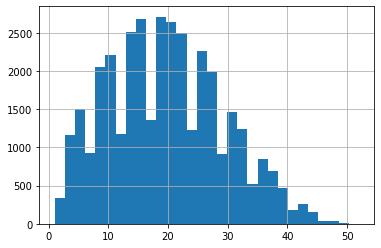

In [ ]:
alllen = [len(i.split()) for i in X_train]
pd.Series(alllen).hist(bins = 30)

tokenize the iuput text

In [ ]:
# tokenize and encode the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

create tensor oject of tokenized input_id, attentio mask, and target values for train, test, and validation datasets

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(Y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(Y_valid.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(Y_test.tolist())

print(train_seq.shape)
print(train_mask.shape)
print(train_y.shape)
print()

print(val_seq.shape)
print(val_mask.shape)
print(val_y.shape)
print()

print(test_seq.shape)
print(test_mask.shape)
print(test_y.shape)

torch.Size([36000, 50])
torch.Size([36000, 50])
torch.Size([36000])

torch.Size([4000, 50])
torch.Size([4000, 50])
torch.Size([4000])

torch.Size([10000, 50])
torch.Size([10000, 50])
torch.Size([10000])


# define the classifier

In [ ]:
class myBERT(nn.Module):

    def __init__(self, bert):
      
      super(myBERT, self).__init__()
      #take in bert base model
      
      self.bert = bert     
      self.dropout = nn.Dropout(0.1)     
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)  #last layer of bert is of size 768
      self.fc2 = nn.Linear(512,2)    
      self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, sent_id, attention_mask):
      
      #pass the inputs to the model  
      output = self.bert(sent_id, attention_mask)

      # print(output.keys()) #odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
      # print('pooler',output['pooler_output'].shape)   #tepooler torch.Size([1, 768])
      # hidden_states = output[2]
      # word_embed_5 = torch.stack(hidden_states[-4:]).sum(0)
      # print('e5',word_embed_5.shape)

      x=self.fc1(output['pooler_output'])
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x


# first define a validation method

In [ ]:
#test everything is alright
tseq=train_seq[0].view(-1,50)
tmask=train_mask[0].view(-1,50)
model=myBERT(bert)
model(tseq,tmask)

tensor([[-0.5052, -0.9248]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
# val_seq val_mask val_y
def getValid():
  
  model.eval()
  with torch.no_grad():
    
    BATCH_SIZE=200
    temp_pred=[]
    validLoss=0

    for i in range(0,len(val_seq),BATCH_SIZE):

      endIndex=min(i+BATCH_SIZE,len(val_seq))
      sent_id=val_seq[i:endIndex].to(device)
      mask=val_mask[i:endIndex].to(device)
      labels=val_y[i:endIndex].to(device)

      output=model(sent_id, mask)    

      predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
      temp_pred.extend(predicted_class) 

      loss = loss_function(output, labels)
      validLoss += loss.item()


    validLoss=round(validLoss /len(val_seq),5)
    validAcc=round(accuracy_score(val_y.tolist(), temp_pred),3)

  return validLoss,validAcc

# Training: Whole Bert Structure

In [ ]:
%%time
# train_seq train_mask train_y 
# val_seq val_mask val_y
# test_seq test_mask test_y 

BATCH_SIZE=100

model=myBERT(bert)
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,len(train_seq),BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(train_seq))
        sent_id=train_seq[i:endIndex].to(device)
        mask=train_mask[i:endIndex].to(device)
        labels=train_y[i:endIndex].to(device)      

        output = model(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / len(train_seq),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   



  0%|          | 0/360 [00:00<?, ?it/s]

Epoch1 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch2 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch3 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch4 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch5 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch6 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch7 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch8 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch9 finished


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch10 finished


100%|██████████| 360/360 [01:37<00:00,  3.67it/s]


CPU times: user 16min 27s, sys: 5.53 s, total: 16min 32s
Wall time: 16min 50s


In [ ]:
torch.save(model.state_dict(), 'NF-bertFull_model_state.bin')

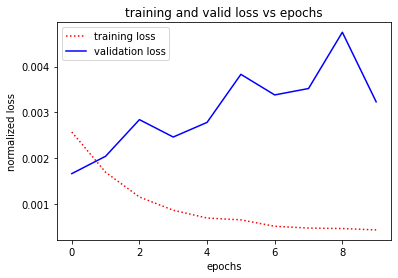

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()



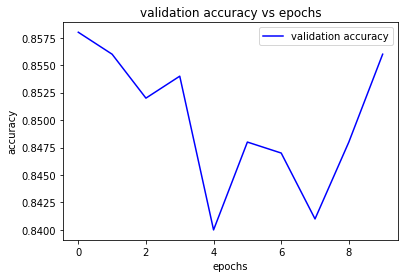

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
# test_seq test_mask test_y 

BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(test_seq))

        sent_id=test_seq[i:endIndex].to(device)
        mask=test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(test_y.tolist(),y_pred))


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5028
           1       0.86      0.86      0.86      4972

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
auth.authenticate_user()

In [ ]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {'name': name,'mimeType': 'application/octet-stream'}
    media = MediaFileUpload(path, mimetype='application/octet-stream',resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

save_file_to_drive('colablTempModel', '/content/NF-bertFull_model_state.bin')

File ID: 1Vzm5xad4dvMkiEUB0zg6EYH62YZsrpIp


{'id': '1Vzm5xad4dvMkiEUB0zg6EYH62YZsrpIp'}

# Training- freeze the entire BERT architecture

In [ ]:
bert=BertModel.from_pretrained('bert-base-uncased')
t=0
for param in bert.parameters():
    t+=1
    param.requires_grad = False
print(t,'layers frozen')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


199 layers frozen


In [ ]:
%%time
# train_seq train_mask train_y 
# val_seq val_mask val_y
# test_seq test_mask test_y 

BATCH_SIZE=100

model=myBERT(bert)
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,len(train_seq),BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(train_seq))
        sent_id=train_seq[i:endIndex].to(device)
        mask=train_mask[i:endIndex].to(device)
        labels=train_y[i:endIndex].to(device)      

        output = model(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / len(train_seq),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   



  1%|          | 2/360 [00:00<00:33, 10.63it/s]

Epoch1 finished


  1%|          | 2/360 [00:00<00:31, 11.36it/s]

Epoch2 finished


  1%|          | 2/360 [00:00<00:32, 11.04it/s]

Epoch3 finished


  1%|          | 2/360 [00:00<00:31, 11.37it/s]

Epoch4 finished


  1%|          | 2/360 [00:00<00:31, 11.26it/s]

Epoch5 finished


  1%|          | 2/360 [00:00<00:31, 11.25it/s]

Epoch6 finished


  1%|          | 2/360 [00:00<00:32, 11.12it/s]

Epoch7 finished


  1%|          | 2/360 [00:00<00:32, 11.01it/s]

Epoch8 finished


  1%|          | 2/360 [00:00<00:31, 11.25it/s]

Epoch9 finished


  1%|          | 2/360 [00:00<00:32, 11.01it/s]

Epoch10 finished


100%|██████████| 360/360 [00:32<00:00, 11.18it/s]


CPU times: user 5min 46s, sys: 2.52 s, total: 5min 49s
Wall time: 5min 52s


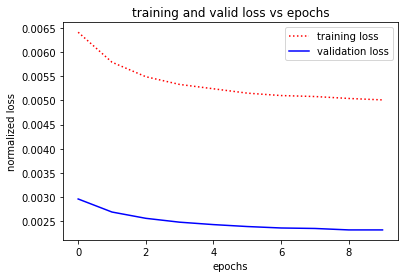

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()

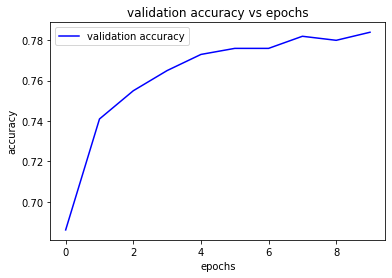

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(test_seq))

        sent_id=test_seq[i:endIndex].to(device)
        mask=test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(test_y.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5028
           1       0.80      0.75      0.78      4972

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



# Training-only tuning on 50% the layers

In [ ]:
t=0
for p in bert.parameters():
  t+=1

print('num of parameter layers in bert base', t)

num of parameter layers in bert base 199


In [ ]:
bert=BertModel.from_pretrained('bert-base-uncased')
t=0
for param in bert.parameters():
    if param.requires_grad == True:
      t+=1
print('number of active layers',t)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


number of active layers 199


In [ ]:
#change all parameters updating to true
bert=BertModel.from_pretrained('bert-base-uncased')
for param in bert.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#freeze half of them
for name, param in list(bert.named_parameters())[:-100]: 
    # print('I will be frozen: {}'.format(name)) 
    param.requires_grad = False


In [ ]:
%%time
# train_seq train_mask train_y 
# val_seq val_mask val_y
# test_seq test_mask test_y 

BATCH_SIZE=100

model=myBERT(bert)
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,len(train_seq),BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(train_seq))
        sent_id=train_seq[i:endIndex].to(device)
        mask=train_mask[i:endIndex].to(device)
        labels=train_y[i:endIndex].to(device)      

        output = model(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / len(train_seq),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   



  0%|          | 1/360 [00:00<01:05,  5.49it/s]

Epoch1 finished


  0%|          | 1/360 [00:00<01:04,  5.58it/s]

Epoch2 finished


  0%|          | 1/360 [00:00<01:02,  5.70it/s]

Epoch3 finished


  0%|          | 1/360 [00:00<01:03,  5.64it/s]

Epoch4 finished


  0%|          | 1/360 [00:00<01:02,  5.74it/s]

Epoch5 finished


  0%|          | 1/360 [00:00<01:04,  5.54it/s]

Epoch6 finished


  0%|          | 1/360 [00:00<01:03,  5.63it/s]

Epoch7 finished


  0%|          | 1/360 [00:00<01:02,  5.72it/s]

Epoch8 finished


  0%|          | 1/360 [00:00<01:04,  5.60it/s]

Epoch9 finished


  0%|          | 1/360 [00:00<01:04,  5.57it/s]

Epoch10 finished


100%|██████████| 360/360 [01:04<00:00,  5.61it/s]


CPU times: user 10min 59s, sys: 4.7 s, total: 11min 4s
Wall time: 11min 13s


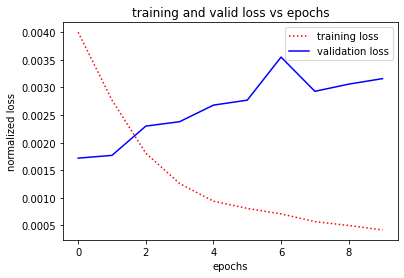

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()

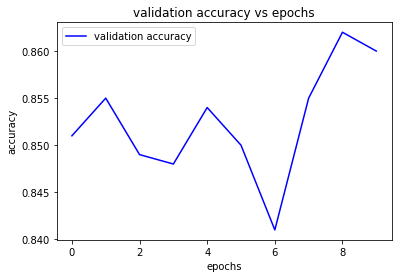

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(test_seq))

        sent_id=test_seq[i:endIndex].to(device)
        mask=test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(test_y.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5028
           1       0.85      0.87      0.86      4972

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# save the model

In [ ]:
import pickle
pickleRes=bert
pickle.dump( pickleRes, open( 'HalfBert.p', "wb" ) )

In [ ]:
p = open('HalfBert.p','rb')
bert = pickle.load(p)
p.close()

In [ ]:
t=0
for param in bert.parameters():
    if param.requires_grad == True:
      t+=1
print('number of active layers',t)

number of active layers 100


In [ ]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {'name': name,'mimeType': 'application/octet-stream'}
    media = MediaFileUpload(path, mimetype='application/octet-stream',resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

save_file_to_drive('halfBert', '/content/HalfBert.p')

File ID: 1O0Yh9pGLmGnrENJ_z3XRePo_4AbgeSZs


{'id': '1O0Yh9pGLmGnrENJ_z3XRePo_4AbgeSZs'}

# Training-freezing 75% of the layers

In [ ]:
bert=BertModel.from_pretrained('bert-base-uncased')
for name, param in list(bert.named_parameters())[:-50]: 
    param.requires_grad = False


In [ ]:
%%time
# train_seq train_mask train_y 
# val_seq val_mask val_y
# test_seq test_mask test_y 

BATCH_SIZE=100

model=myBERT(bert)
model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10


train_loss=[]
val_loss=[]
val_acc=[]

model.train()   

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,len(train_seq),BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(train_seq))
        sent_id=train_seq[i:endIndex].to(device)
        mask=train_mask[i:endIndex].to(device)
        labels=train_y[i:endIndex].to(device)      

        output = model(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / len(train_seq),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   



  0%|          | 1/360 [00:00<00:51,  7.01it/s]

Epoch1 finished


  0%|          | 1/360 [00:00<00:46,  7.68it/s]

Epoch2 finished


  0%|          | 1/360 [00:00<00:46,  7.64it/s]

Epoch3 finished


  0%|          | 1/360 [00:00<00:46,  7.65it/s]

Epoch4 finished


  0%|          | 1/360 [00:00<00:47,  7.59it/s]

Epoch5 finished


  0%|          | 1/360 [00:00<00:47,  7.52it/s]

Epoch6 finished


  0%|          | 1/360 [00:00<00:46,  7.65it/s]

Epoch7 finished


  0%|          | 1/360 [00:00<00:47,  7.52it/s]

Epoch8 finished


  0%|          | 1/360 [00:00<00:46,  7.71it/s]

Epoch9 finished


  0%|          | 1/360 [00:00<00:47,  7.56it/s]

Epoch10 finished


100%|██████████| 360/360 [00:47<00:00,  7.58it/s]


CPU times: user 8min 14s, sys: 3.99 s, total: 8min 18s
Wall time: 8min 25s


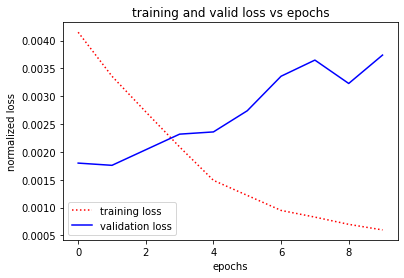

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()

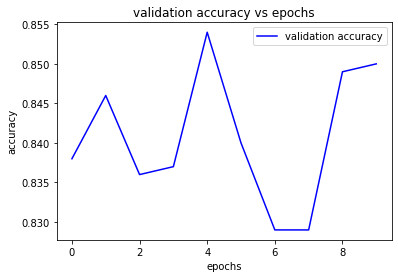

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(test_seq))

        sent_id=test_seq[i:endIndex].to(device)
        mask=test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(test_y.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5028
           1       0.83      0.85      0.84      4972

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# test for using scheduler

In [ ]:
bert=BertModel.from_pretrained('bert-base-uncased')
for name, param in list(bert.named_parameters())[:-100]: 
    param.requires_grad = False


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%%time
# train_seq train_mask train_y 
# val_seq val_mask val_y
# test_seq test_mask test_y 

BATCH_SIZE=64

model=myBERT(bert)
model.to(device)

optimizer = AdamW(model.parameters(),lr = 2e-5)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10

total_steps = (int(len(train_seq)/BATCH_SIZE)+1) * num_epochs
scheduler=get_linear_schedule_with_warmup( optimizer,num_warmup_steps=0,
        num_training_steps=total_steps
)

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'finished')
    trainLoss = 0

    for i in tqdm(range(0,len(train_seq),BATCH_SIZE)):

        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(train_seq))
        sent_id=train_seq[i:endIndex].to(device)
        mask=train_mask[i:endIndex].to(device)
        labels=train_y[i:endIndex].to(device)      

        output = model(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()
        loss.backward()      
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 
        scheduler.step()               
    
    trainLoss=round(trainLoss / len(train_seq),5)      
    validLoss,validAcc=getValid()

    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)

    model.train()   



  0%|          | 1/563 [00:00<01:10,  7.93it/s]

Epoch1 finished


  0%|          | 1/563 [00:00<01:06,  8.50it/s]

Epoch2 finished


  0%|          | 1/563 [00:00<01:06,  8.50it/s]

Epoch3 finished


  0%|          | 1/563 [00:00<01:07,  8.28it/s]

Epoch4 finished


  0%|          | 1/563 [00:00<01:06,  8.50it/s]

Epoch5 finished


  0%|          | 1/563 [00:00<01:06,  8.49it/s]

Epoch6 finished


  0%|          | 1/563 [00:00<01:06,  8.39it/s]

Epoch7 finished


  0%|          | 1/563 [00:00<01:06,  8.39it/s]

Epoch8 finished


  0%|          | 1/563 [00:00<01:07,  8.34it/s]

Epoch9 finished


  0%|          | 1/563 [00:00<01:07,  8.38it/s]

Epoch10 finished


100%|██████████| 563/563 [01:07<00:00,  8.36it/s]


CPU times: user 11min 25s, sys: 5.95 s, total: 11min 31s
Wall time: 11min 44s


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()
with torch.no_grad():
     for i in tqdm(range(0,len(test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(test_seq))

        sent_id=test_seq[i:endIndex].to(device)
        mask=test_mask[i:endIndex].to(device)

        output=model(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(test_y.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


              precision    recall  f1-score   support

           0       0.85      0.86      0.86      5028
           1       0.86      0.85      0.85      4972

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

